## Import library

In [2]:
from datetime import datetime
from typing import Optional, Literal
from pydantic import BaseModel

import numpy as np
import scipy.special as sp
from scipy.constants import physical_constants, m_e, m_p

from matplotlib import patheffects, ticker, colors
import matplotlib.pyplot as plt
import seaborn as sns

## Koreksi Massa Tereduksi
Koreksi massa tereduksi $(\mu)$ digunakan untuk memperhitungkan massa inti yang terbatas. Untuk menghitung massa tereduksi, kita menggunakan persamaan ini:$$\mu=\frac{m_eM}{m_e+M}$$
Definisi:
- $m_e$ : Massa elektron ($9.109\times 10^{-31}$ kg)
- $M$ : Massa inti atom (untuk Hidrogen, $M\approx m_p=1.007825031898(14)$ Da)

In [3]:
def reduced_electron_nucleus_mass(Z: int, M: Optional[float] = None):
    """ Compute electron–nucleus reduced mass μ.

        Parameters:
            Z (int): Nuclear charge number. (Z=1 for Hydrogen, Z>1 for hydrogenic ions).
            M (float): Nuclear mass in kg.

        Returns:
            float: Two-body (electron + nucleus) system reduced mass μ in kilograms.

        Notes:
            - If Z>1, M must be provided.
            - If Z=1 and M is not provided, proton mass m_p is assumed.
    """
    if M is None:
        if Z == 1:
            M = m_p
        else:
            raise ValueError("'M' must be provided if Z>1")

    return (m_e * M) / (m_e + M)

## Reduksi Radius Bohr

Reduksi massa elektron mengakibatkan jari-jari Bohr juga tereduksi melalui persamaan berikut: $$a_{\mu}=a_0\frac{m_e}{\mu}$$
Definisi:
- $a_{mu}$ : Jari-jari Bohr yang telah tereduksi
- $a_0$ : Jari-jari Bohr
Menetapkan $a_{\mu}\to a_0$ akan memengaruhi model yang menggunakan asumsi perkiraan massa inti tak terbatas.

In [4]:
def reduced_bohr_radius(mu: float):
    """ Compute Bohr radius evaluated with a reduced mass.

        Parameters:
            mu (float): Electron–nucleus reduced mass μ in kg.

        Returns:
            float: Reduced-mass Bohr radius a_μ in meters.
    """
    a0 = physical_constants["Bohr radius"][0]
    return a0 * (m_e / mu)

# Fungsi Gelombang Bagian Radial
Komponen radial ini memberi kita wawasan tentang distribusi probabilitas elektron sebagai fungsi jarak $(r)$ dari inti.
- Peluruhan eksponensial: bagian ini menunjukkan bahwa probabilitas untuk menemukan elektron akan meluruh secara eksponensial sementara jarak dari inti semakin jauh. Dalam variabel ini, $a_{\mu}$ adalah jari-jari Bohr massa tereduksi, yang menetapkan skala panjang karakteristik. Sedangkan $Z$ adalah skala konstanta peluruhan. Bagian ini terdiri dari: $$e^{\frac{Zr}{na_{\mu}}}$$
- Suku pangkat: Bagian ini menunjukkan bagaimana probabilitas berubah dengan $r$. Variabel ini bergantung pada bilangan kuantum azimut $(l)$. Ini akan mengatur perilaku di dekat titik asal dan jumlah simpul radial. Bagian ini terdiri dari: $$\bigg(\frac{2Zr}{na_{\mu}}\bigg)^l$$
- Polinomial Laguerre terkait: Polinomial ini berkontribusi pada struktur yang lebih halus pada bagian radial, ini akan mendefinisikan simpul. Bagian ini terdiri dari:$$L_{n-l-1}^{2l+1}!\bigg(\frac{2Zr}{na_{\mu}}\bigg)$$
- Faktor pendahulu normalisasi stabil: Faktor ini ditambahkan untuk membuat fungsi lebih stabil. Bagian ini terdiri dari: $$\bigg(\frac{2Z}{na_{\mu}}\bigg)^{3/2}\sqrt{\frac{(n-l-1)!}{2n(n+l)!}}$$
Bentuk lengkap komponen radial dari fungsi gelombang ditunjukkan di bawah ini:$$R_{nl}(r)=\bigg(\frac{2Z}{na_{\mu}}\bigg)^{3/2}\sqrt{\frac{(n-l-1)!}{2n(n+l)!}}e^{-\frac{Zr}{na_{\mu}}}\bigg(\frac{2Zr}{na_{\mu}}\bigg)^lL_{n-l-1}^{2l+1}\bigg(\frac{2Zr}{na_{\mu}}\bigg)$$

In [5]:
def radial_wavefunction_Rnl(
        n: int,
        l: int,
        r: np.ndarray,
        Z: int = 1,
        use_reduced_mass: bool = True,
        M: Optional[float] = None
):
    """ Normalized hydrogenic radial wavefunction R_{n,l}(r).

        Parameters:
            n (int): Principal quantum number (n ≥ 1).
            l (int): Orbital angular-momentum quantum number (0 ≤ l ≤ n-1).
            r (np.ndarray): Radial coordinate(s) in meters.
            Z (int): Nuclear charge number. (Z=1 for Hydrogen, Z>1 for hydrogenic ions).
            use_reduced_mass (bool): Reduced-mass μ correction in Bohr radius.
            M (float): Nuclear mass in kg.

        Returns:
            R (np.ndarray): Real-valued radial eigenfunction samples with broadcasted shape of (r).

        Notes:
            - R has units of m^{-3/2}.
            - If use_reduced_mass = True, evaluate the Bohr radius with an electron–nucleus reduced mass μ,
              otherwise, use invariant electron mass m_e (μ = m_e ∴ a_μ = a₀) in the infinite–mass approximation.
            - If Z>1 and use_reduced_mass = True, M must be provided.
            - If Z=1 and M is not provided, proton mass m_p is assumed.
    """
    if not (n >= 1 and 0 <= l <= n - 1):
        raise ValueError("(!) Quantum numbers (n,l) must satisfy n ≥ 1 and 0 ≤ l ≤ n-1")

    mu = reduced_electron_nucleus_mass(Z, M) if use_reduced_mass else m_e
    a_mu = reduced_bohr_radius(mu)

    rho = 2.0 * Z * r / (n * a_mu)
    L = sp.eval_genlaguerre(n - l - 1, 2 * l + 1, rho)

    # Stable normalization prefactor using log-gamma
    # pref = (2Z/(n a_mu))^(3/2) * sqrt( (n-l-1)! / (2n * (n+l)!))

    log_pref = 1.5 * np.log(2.0 * Z / (n * a_mu))
    log_pref += 0.5 * (sp.gammaln(n - l) - (np.log(2.0 * n) + sp.gammaln(n + l + 1)))
    pref = np.exp(log_pref)
    R = pref * np.exp(-rho / 2.0) * np.power(rho, l) * L
    return R

# Fungsi Gelombang Bagian Angular
Fungsi gelombang sudut membuat fungsi gelombang bergantung pada sudut polar ($\theta$) dan sudut azimut ($\phi$). Koordinat bola ini memberikan penjelasan rinci tentang bentuk dan orientasi orbital atom. Bentuk dan orientasi ini mencirikan bagaimana probabilitas elektron terdistribusi di ruang angkasa.
- Polinomial Legendre: Polinomial ini menentukan bagaimana bentuk orbital dalam arah polar ($\theta$). Ini membantu dalam mendefinisikan karakteristik bentuk (`s,p,d,f`). Bagian ini terdiri dari: $$P_{l}^{m}(\cos{\theta})$$
- Istilah azimut eksponensial: Bagian ini memberikan orientasi bidang azimut orbital. Bagian ini bergantung pada bilangan kuantum magnetik. Bagian ini terdiri dari: $$e^{im\phi}$$

Persamaan lengkap untuk bagian ini diberikan di bawah ini: $$Y_{l}^{m}(\theta,\phi)=(-1)^m\sqrt{\frac{(2l+1)}{4\pi}\frac{(l-m)!}{(l+m)!}}P_{l}^{m}(\cos \theta)e^{im\phi}$$

In [6]:
def spherical_harmonic_Ylm(
        l: int,
        m: int,
        theta: np.ndarray,
        phi: np.ndarray
):
    """ Complex spherical harmonic Y_{l,m}(theta,phi); orthonormal on S².

        Parameters:
            l (int): Orbital angular-momentum quantum number (l ≥ 0).
            m (int): Magnetic quantum number (-l ≤ m ≤ l).
            theta (np.ndarray): Polar angle(s) in radians in the interval theta ∈ [0, π].
            phi (np.ndarray): Azimuthal angle(s) in radians in the interval phi ∈ [0, 2π).

        Returns:
            Y (np.ndarray): Complex-valued spherical harmonic with broadcasted shape of (theta, phi).
    """
    if not (l >= 0 and -l <= m <= l):
        raise ValueError("(!) Quantum numbers (l,m) must satisfy l ≥ 0 and -l ≤ m ≤ l")

    theta = np.asarray(theta, dtype=float)
    phi = np.asarray(phi, dtype=float)
    Y = sp.sph_harm_y(l, m, theta, phi)
    return Y

# Normalisasi Fungsi Gelombang
Resultan dari fungsi gelombang yang dinormalisasi adalah hasil perkalian solusi komponen radial dan angular. Fungsi gelombang yang dinormalisasi seharusnya memberikan: $$\psi_{nlm}(r,\theta,\phi)=R_{nl}(r)Y_{l}^{m}(\theta,\phi)$$

In [7]:
def compute_psi_xz_slice(
    n: int,
    l: int,
    m: int,
    Z: int = 1,
    use_reduced_mass: bool = True,
    M: Optional[float] = None,
    extent_a_mu: float = 20.0,
    grid_points: int = 600,
    phi_value: float = 0.0,
    phi_mode: Literal["plane", "constant"] = "plane"
):
    """ Evaluate psi_{n,l,m}(x,0,z), hydrogenic eigenfunction restricted to the y=0 (x–z) plane.

        Parameters:
            n (int): Principal quantum number (n ≥ 1).
            l (int): Orbital angular-momentum quantum number (0 ≤ l ≤ n-1).
            m (int): Magnetic quantum number (-l ≤ m ≤ l).
            Z (int): Nuclear charge number. (Z=1 for Hydrogen, Z>1 for hydrogenic ions).
            use_reduced_mass (bool): Reduced-mass μ correction in Bohr radius.
            M (float): Nuclear mass in kg.
            extent_a_mu (float): Half-width of the square grid in units of the reduced-mass Bohr radius.
            grid_points (int): Number of points per Cartesian axis.
            phi_value (float): Azimuth phi (radians); Only used if phi_mode="constant".
            phi_mode (str): Azimuthal prescription on y=0.

        Returns:
            Xg (np.ndarray): 2D Cartesian x-coordinate grid (y=0) in meters.
            Zg (np.ndarray): 2D Cartesian z-coordinate grid (y=0) in meters.
            psi (np.ndarray): Complex-valued coordinate-space wavefunction samples psi(x,z) on y=0.
            a_mu (float): Reduced-mass Bohr radius a_μ in meters.

        Notes:
            - psi has units of m^{-3/2}.
            - If use_reduced_mass = True, evaluate the Bohr radius with an electron–nucleus reduced mass μ,
              otherwise, use invariant electron mass m_e (μ = m_e ∴ a_μ = a₀) in the infinite–mass approximation.
            - If Z>1 and use_reduced_mass = True, M must be provided.
            - If Z=1 and M is not provided, proton mass m_p is assumed.
            - Xg, Zg and psi have the shape (grid_points, grid_points).
            - If phi_mode = "plane", phi=0 for x ≥ 0, phi = π for x < 0.
            - If phi_mode = "constant", phi ≡ phi_value across the grid.
    """
    if not (n >= 1 and 0 <= l <= n - 1 and -l <= m <= l):
        raise ValueError("(!) Quantum numbers (n,l,m) must satisfy n ≥ 1, 0 ≤ l ≤ n-1, and -l ≤ m ≤ l")

    mu = reduced_electron_nucleus_mass(Z, M) if use_reduced_mass else m_e
    a_mu = reduced_bohr_radius(mu)

    r_max = extent_a_mu * a_mu
    axis = np.linspace(-r_max, r_max, grid_points)
    Zg, Xg = np.meshgrid(axis, axis, indexing="ij")

    r = np.hypot(Xg, Zg)
    cos_theta = np.empty_like(r)
    np.divide(Zg, r, out=cos_theta, where=(r > 0))
    cos_theta[r == 0] = 1.0

    theta = np.arccos(np.clip(cos_theta, -1.0, 1.0))
    phi = np.where(Xg >= 0.0, 0.0, np.pi) if phi_mode == "plane" else np.full_like(r, float(phi_value))

    # Compute psi_{n,l,m}(r,theta,phi) = R_{n,l}(r) · Y_{l,m}(theta,phi)
    R = radial_wavefunction_Rnl(n, l, r, Z=Z, use_reduced_mass=use_reduced_mass, M=M)
    Y = spherical_harmonic_Ylm(l, m, theta, phi)
    psi = R * Y

    return Xg, Zg, psi, a_mu

# Densitas Probabilitas Menemukan Elektron
Densitas probabilitas di lokasi tertentu dihitung dengan mengambil kuadrat magnitudo fungsi gelombang di seluruh ruang $|\psi_{nlm}|^2$. Bagian ini memberikan: $$P(r,\theta,\phi)=|\psi_{nlm}(r,\theta,\phi)|^2$$

In [8]:
def compute_probability_density(psi: np.ndarray):
    """ Retrieve probability density |psi|^2.

        Parameters:
            psi (np.ndarray): Complex-valued coordinate-space wavefunction samples psi(x,z) on y=0.

        Returns:
            P (np.ndarray): Real-valued |psi|^2 with the same shape as psi.
    """
    return np.abs(psi) ** 2

# Distribusi Probabilitas Radial
Distribusi probabilitas radial menggambarkan probabilitas menemukan elektron di antara $r$ dan $r+dr$.$$P_{nl}(r)=r^2|R_{nl}(r)|^2$$

In [18]:
def compute_radial_probability_distribution(R: np.ndarray, r: np.ndarray):
    """ Retrieve Radial probability distribution P_{n,l}(r) = r^2 * |R_{n,l}(r)|^2.

        Parameters:
            R (np.ndarray): Real-valued radial eigenfunction samples R_{n,l}(r).
            r (np.ndarray): Radial coordinate(s) in meters.

        Returns:
            P_r (np.ndarray): Real-valued P_{n,l}(r) with the same shape as r.
    """
    return (r**2) * np.abs(R) ** 2

# Visualisasi
Visualisasi akan diberikan dalam bidang 2D. Sehingga, persamaannya akan menjadi:
$$\psi_{nlm}(x,0,z)=R_{nl}(r)Y_{l}^{m}(\theta,\phi),~~~r=\sqrt{x^2+0^2+z^2},~~~\cos\theta=\frac{z}{r}$$

In [19]:
class WaveFunction(BaseModel):
    """ Wavefunction schema.
        [Composite of 'hydrogen_wavefunction.compute_psi_xz_slice'].
    """
    n: int
    l: int
    m: int
    Z: int = 1
    use_reduced_mass: bool = True
    M: Optional[float] = None
    extent_a_mu: float = 20.0
    grid_points: int = 600
    phi_value: float = 0.0
    phi_mode: Literal["plane", "constant"] = "plane"

def plot_hydrogen_wavefunction_xz(
    wf: WaveFunction,
    colormap: str = "rocket",
    use_dark_theme: bool = False,
    k: Optional[float] = None,
    exposure: Optional[float] = 0.0
):
    if k is not None:
        wf.extent_a_mu = float(k * (3 * wf.n**2 - wf.l * (wf.l + 1)) / (2 * wf.Z))

    # --- Wavefunction slice ---
    Xg, Zg, psi, a_mu = compute_psi_xz_slice(
        n=wf.n, l=wf.l, m=wf.m, Z=wf.Z,
        use_reduced_mass=wf.use_reduced_mass,
        M=wf.M,
        extent_a_mu=wf.extent_a_mu,
        grid_points=wf.grid_points,
        phi_value=wf.phi_value,
        phi_mode=wf.phi_mode,
    )

    P = compute_probability_density(psi)

    # --- Radial distribution ---
    r = np.linspace(0.0, wf.extent_a_mu * a_mu, 5000)

    R = radial_wavefunction_Rnl(
        n=wf.n, l=wf.l, r=r,
        Z=wf.Z,
        use_reduced_mass=wf.use_reduced_mass,
        M=wf.M
    )

    P_r = compute_radial_probability_distribution(R, r)
    idx_max = np.argmax(P_r)
    r_max = r[idx_max]

    # Menentukan parameter tampilan umum
    cmap = sns.color_palette(colormap, as_cmap=True)
    extent = (Xg.min() / a_mu, Xg.max() / a_mu, Zg.min() / a_mu, Zg.max() / a_mu)

    # ---------- FIGURE 1: Plot 2D |psi|^2 ----------
    plt.figure(figsize=(60, 30))
    im = plt.imshow(
        P, extent=extent,
        origin="lower", aspect="equal",
        cmap=cmap
    )

    plt.xlabel(r"$x / a_\mu$", fontsize=30)
    plt.ylabel(r"$z / a_\mu$", fontsize=30)
    plt.title(r"$|\psi(x,z)|^2$", fontsize=45)
    plt.tick_params(axis='both', labelsize=30)

    cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
    cbar.set_label(r"$|\psi|^2\;[\mathrm{m}^{-3}]$", fontsize=30)
    cbar.ax.tick_params(labelsize=30)
    cbar.ax.yaxis.get_offset_text().set_fontsize(30)

    plt.text(
        0.04, 0.95,
        f"(n,l,m)=({wf.n},{wf.l},{wf.m})",
        transform=plt.gca().transAxes,
        fontsize=30,
        ha="left", va="top",
        color="white",
        path_effects=[patheffects.withStroke(linewidth=3, foreground="black")]
    )
    plt.show() # Menampilkan gambar pertama

    # ---------- FIGURE 2: Plot Radial Probability ----------
    plt.figure(figsize=(50, 20))
    plt.plot(r / a_mu, P_r, linewidth=2)
    plt.axvline(
        r_max / a_mu, color="r", linestyle="--",
        label=rf"$r_{{\max}} = {r_max/a_mu:.2f}\,a_\mu$"
    )

    plt.xlabel(r"$r / a_\mu$", fontsize=30)
    plt.ylabel(r"$P_{n\ell}(r)$", fontsize=30)
    plt.title("Radial Probability Distribution", fontsize=45)
    plt.tick_params(axis='both', labelsize=30)
    plt.grid(True)
    plt.legend(fontsize=30)
    plt.show() # Menampilkan gambar kedua

    print("Radius dengan probabilitas maksimum adalah: ", r_max / a_mu)


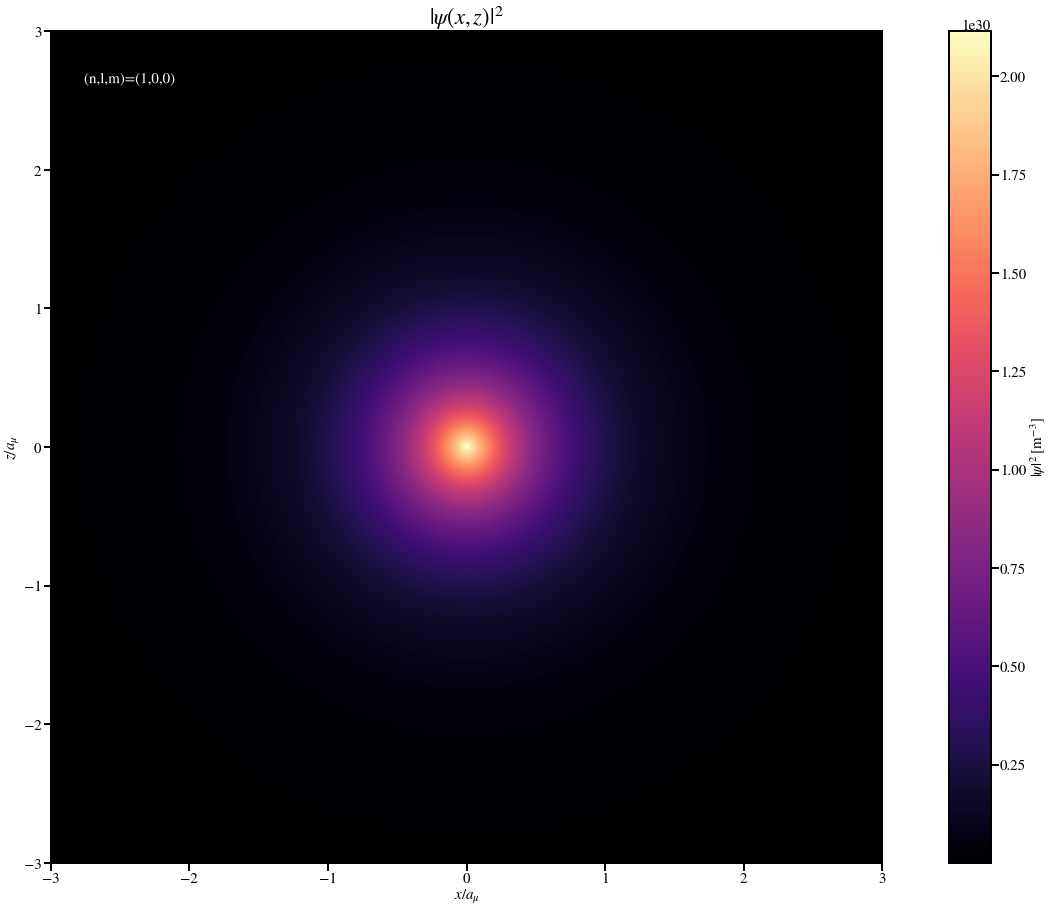

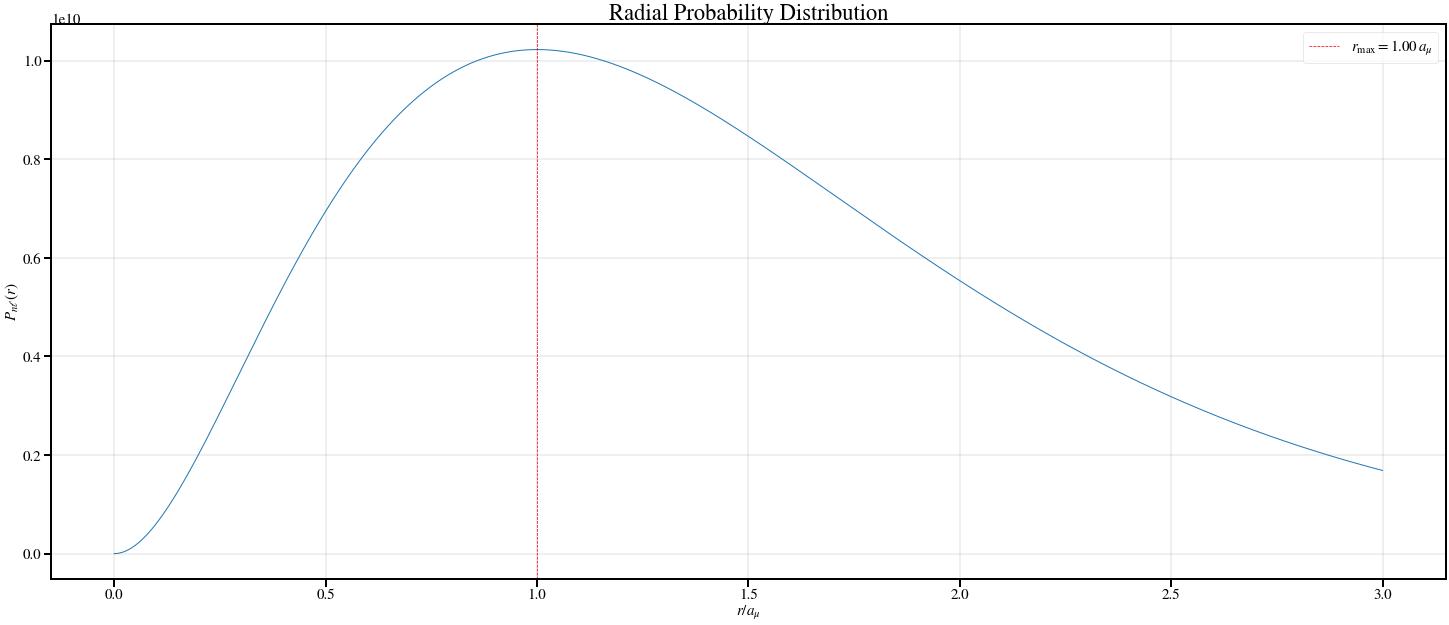

Radius dengan probabilitas maksimum adalah:  0.9997999599919983


In [20]:
plt.rcParams["figure.dpi"] = 36
wf = WaveFunction(n=1, l=0, m=0)
plot_hydrogen_wavefunction_xz(wf, colormap="magma", k=2)